<a id = "head"></a>
# Событийная аналитика: поведение пользователей мобильного приложения

---

### Описание проекта

В стартапе, который продаёт продукты питания, есть мобильное приложение. Нужно разобраться, как ведут себя пользователи данного приложения.
Необходимо изучить воронку продаж, а затем исследовать результаты A/A/B-эксперимента. 

### Описание данных

Каждая запись в логе — это действие пользователя, или событие.

- `EventName` — название события;
- `DeviceIDHash` — уникальный идентификатор пользователя;
- `EventTimestamp` — время события;
- `ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

### *План выполнения проекта:*
***

1. [Изучение общей информации о данных;](#Step1)
2. [Подготовка данных;](#Step2)
3. [Изучение и проверка данных;](#Step3)
4. [Изучение воронки событий;](#Step4)
5. [Изучение результатов эксперимента;](#Step5)
6. [Общий вывод по проекту.](#Step6)

<a id = "Step1"></a>
### Шаг 1. Изучение общей информации о данных
---

In [1]:
# Импорт библиотек:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math
import seaborn as sns
import matplotlib.ticker as ticker
from termcolor import colored

In [3]:
logs = pd.read_csv(r'C:\Users\vladi\Downloads\data_for_analysis\logs_exp.csv', sep = '\t')

In [4]:
logs.sample(10)

,EventName,DeviceIDHash,EventTimestamp,ExpId
75463,CartScreenAppear,4980045449118619005,1564801731,247
150385,MainScreenAppear,1715549896674297417,1564997573,248
118248,CartScreenAppear,957126200348560045,1564913831,248
194906,MainScreenAppear,8428475778843880860,1565097064,246
144160,MainScreenAppear,288947541653489764,1564984121,248
164370,PaymentScreenSuccessful,1529531054838639703,1565018241,247
109093,MainScreenAppear,4970743548096192138,1564891526,246
7395,CartScreenAppear,3776850235681345880,1564642261,247
131281,OffersScreenAppear,1836871388568984876,1564934127,247
229091,OffersScreenAppear,4163043361639277460,1565183939,247


In [4]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
EventName         244126 non-null object
DeviceIDHash      244126 non-null int64
EventTimestamp    244126 non-null int64
ExpId             244126 non-null int64
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [5]:
logs.duplicated().sum()

413

Найдено 413 повторяющихся строк. Удалим их.

In [6]:
logs = logs.drop_duplicates().reset_index(drop = True)

In [7]:
logs.shape

(243713, 4)

---
В таблице содержится информация о 243713 уникальных действиях пользователей. Время события указано в формате Unix.

<a id = "Step2"></a>
### Шаг 2. Подготовка данных
---

- [Начало](#head)
- [Шаг 1](#Step1)
- [Шаг 3](#Step3)
- [Шаг 4](#Step4)
- [Шаг 5](#Step5)
- [Шаг 6](#Step6)


Изменим названия стобцов.

In [8]:
logs.columns = ['event_name', 'user_id', 'event_time', 'group']

In [9]:
logs.isna().sum()

event_name    0
user_id       0
event_time    0
group         0
dtype: int64

Пропусков не обнаружено.

---
Изменим тип данных в столбце со временем события.

In [10]:
logs['event_time'] = pd.to_datetime(logs['event_time'], unit = 's')
#logs.head()

Таким образом мы получили необходимый столбец с датой и временем.

---

Выделим отдельный столбец, значения которого будут содержать только дату.

In [11]:
logs['date'] = logs['event_time'].astype('datetime64[D]')
#logs.info

In [12]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 5 columns):
event_name    243713 non-null object
user_id       243713 non-null int64
event_time    243713 non-null datetime64[ns]
group         243713 non-null int64
date          243713 non-null datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 9.3+ MB


<a id = "Step3"></a>
### Шаг 3. Изучение и проверка данных
---

- [Начало](#head)
- [Шаг 1](#Step1)
- [Шаг 2](#Step2)
- [Шаг 4](#Step4)
- [Шаг 5](#Step5)
- [Шаг 6](#Step6)


In [13]:
logs['event_name'].value_counts()

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64

In [14]:
len(logs)

243713

---
**В логах содержатся пять видов событий. Всего 243713 записей.**

In [15]:
logs['user_id'].nunique()

7551

---
**В данных находится 7551 пользователь.**

In [16]:
round(len(logs) / logs['user_id'].nunique())

32

---
**В среднем на одного пользователя приходится 32 события.**

In [17]:
logs['event_time'].min()

Timestamp('2019-07-25 04:43:36')

In [18]:
logs['event_time'].max()

Timestamp('2019-08-07 21:15:17')

In [19]:
logs['event_time'].max() - logs['event_time'].min()

Timedelta('13 days 16:31:41')

**В таблице содержатся данные о событиях, произошедших с 04:43:36 25.07.2019 г. по 21:15:17 07.08.2019 г.**

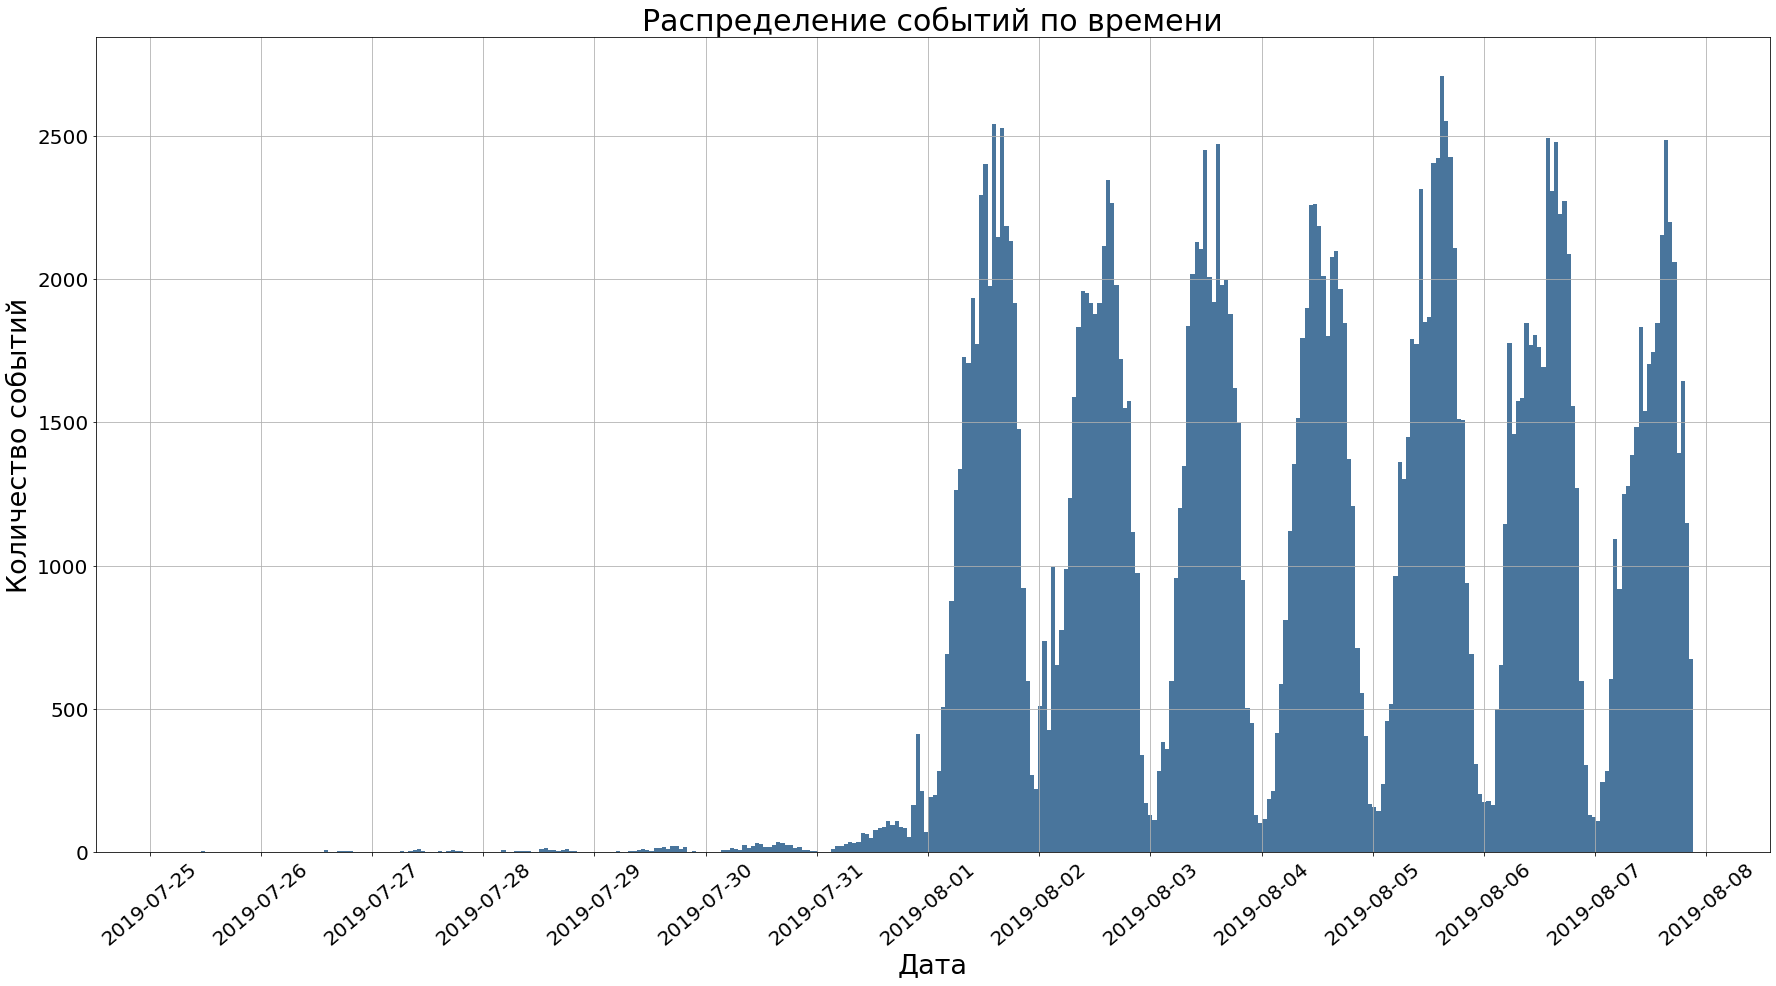

In [20]:
# Построим гистограмму:
import warnings
warnings.filterwarnings('ignore')


logs['event_time'].hist(bins = 360, figsize = (30,15), color = '#49759c')
    
plt.title("Распределение событий по времени", fontsize=30)
plt.ylabel("Количество событий", fontsize = 27)
plt.xlabel("Дата", fontsize = 27)

xtick_major = np.arange(logs['date'].min(), logs['date'].max()+pd.Timedelta(days=2), pd.Timedelta(days=1))

plt.xticks(ticks=xtick_major, fontsize=20, rotation = 40)
plt.yticks(fontsize=20)
plt.axis(option = 'normal');

**Фактически данные за первые 7 дней получились неполными - очень мало событий произошло за этот период. Нормальная пользовательская активность начинается накануне 1 августа. Отбросим данные по 31.07.2019 21:00:00 и получим практически ровно неделю наблюдений.**

In [21]:
logs_new = logs[logs['event_time'] >= '2019-07-31 21:00:00'].reset_index(drop=True)

In [22]:
len(logs) - len(logs_new)

1989

In [23]:
len(logs_new)/len(logs)

0.9918387611657975

In [24]:
logs['user_id'].nunique() - logs_new['user_id'].nunique()

13

---
**Отбросив старые данные мы потеряли 1989 событий и 13 пользователей.**

In [25]:
logs_new['group'].unique()

array([247, 248, 246])

---  
**Пользователи всех экспериментальных групп присутствуют в обновленном логе.**

<a id = "Step4"></a>
### Шаг 4. Изучение воронки событий
---

- [Начало](#head)
- [Шаг 1](#Step1)
- [Шаг 2](#Step2)
- [Шаг 3](#Step3)
- [Шаг 5](#Step5)
- [Шаг 6](#Step6)

In [26]:
logs_new['event_name'].value_counts()

MainScreenAppear           117889
OffersScreenAppear          46531
CartScreenAppear            42343
PaymentScreenSuccessful     33951
Tutorial                     1010
Name: event_name, dtype: int64

In [27]:
logs_new['event_name'].value_counts()[3] / logs_new['event_name'].value_counts().sum()

0.14045357515182605

**`Виды событий:`**

- MainScreenAppear - Просмотр главного экрана приложения 
- OffersScreenAppear - Просмотр предложения о покупке (или карточки товара)
- CartScreenAppear - Просмотр корзины
- PaymentScreenSuccessful - Оплата покупки
- Tutorial - Просмотр руководства      

Около половины всех событий в логах - это просмотр главного экрана приложения. Меньше всего пользователи обращают внимаение на руководство. 14% всех событий составляют покупки.

In [28]:
event_pivot = logs_new.pivot_table(index = 'event_name', 
                                 values = 'user_id', 
                                 aggfunc ={'user_id':'nunique'}, margins=True)

event_pivot = event_pivot.rename({'user_id':'user_count'}, axis = 1).sort_values(by='user_count', ascending = False)

event_pivot['share_of_all'] = round((event_pivot['user_count'] / event_pivot.loc['All', 'user_count']),4)

event_pivot.style.format({'share_of_all': "{:.1%}"}).bar(subset = ['share_of_all'], color='#5fba7d')

,user_count,share_of_all
event_name,,
All,7538,100.0%
MainScreenAppear,7423,98.5%
OffersScreenAppear,4597,61.0%
CartScreenAppear,3736,49.6%
PaymentScreenSuccessful,3540,47.0%
Tutorial,843,11.2%


Обычно после установки приложения каждый пользователь попадает на главную страницу. Однако в нашем случае часть пользователей прошла мимо этого этапа. Вероятно в приложении есть возможность совершать какие-либо другие действия, минуя основную страницу. Этот момент необходимо уточнить у разработчиков. `47%` всех пользователей хотя бы раз совершали покупки - хороший показатель. 

In [29]:
(logs_new.groupby('user_id')['event_name'].first() == 'Tutorial').sum()

787

---
Предположим, что события происходят в следующем порядке: 
1. "MainScreenAppear";
2. "OffersScreenAppear";
3. "CartScreenAppear";
4. "PaymentScreenSuccessful". 

Судя по тому, что инструкцию хотя бы раз открывали только 11.2% от всех пользователей, учитывать при расчете воронки данное событие не следует. Вероятно, это действие добровольное и особо не влияет на совершение покупок в магазине. Среди тех, кто читал руководство, большая часть пользователей (787 человек) делала это в первую очередь.

In [30]:
funnel = logs_new[logs_new['event_name'] != 'Tutorial'].pivot_table(index = 'event_name', 
                                 values = 'user_id', aggfunc ={'user_id':'nunique'})\
    .rename({'user_id':'user_count'}, axis=1).sort_values(by = 'user_count', ascending = False)
funnel

,user_count
event_name,
MainScreenAppear,7423
OffersScreenAppear,4597
CartScreenAppear,3736
PaymentScreenSuccessful,3540


In [31]:
funnel['conversion_ns'] = funnel['user_count'].shift(1)

In [32]:
funnel.loc['MainScreenAppear', 'conversion_ns'] = 7423

In [33]:
funnel['conversion_ns'] =  funnel['user_count'] / funnel['conversion_ns']

In [34]:
funnel.style.format({'conversion_ns': "{:.1%}"})

,user_count,conversion_ns
event_name,,
MainScreenAppear,7423,100.0%
OffersScreenAppear,4597,61.9%
CartScreenAppear,3736,81.3%
PaymentScreenSuccessful,3540,94.8%


In [35]:
funnel.loc['PaymentScreenSuccessful', 'user_count'] / funnel.loc['MainScreenAppear', 'user_count'] * 100

47.68961336386906

---
**Полученная воронка показывает, что больше всего пользователей уходит на втором шаге - `38.1%` уходит  после просмотра основной страницы.** Довольно высокие показатели на следующих этапах воронки. Из 4597 пользователей, которые получали предложение о товаре (или карточку товара) 81.3% перешли в корзину товаров. А из тех, кто заходил в корзину, товар купили 94.8%.

**Также мы выяснили, что от первого события до оплаты дошло `47.7%`.**

#### Дополнительно построим воронку с учётом последовательности событий
---

Для начала по каждому пользователю посчитаем, в какое время он впервые совершил определённое событие. Затем найдем тех, чьи события происходили в нужном порядке.

In [36]:
users = logs_new[logs_new['event_name'] != 'Tutorial'].pivot_table(
    index='user_id', 
    columns='event_name', 
    values='event_time',
    aggfunc='min')

In [37]:
users.head()

event_name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful
user_id,,,,
6888746892508752,NaT,2019-08-06 14:06:34,NaT,NaT
6909561520679493,2019-08-06 18:52:58,2019-08-06 18:52:54,2019-08-06 18:53:04,2019-08-06 18:52:58
6922444491712477,2019-08-04 14:19:40,2019-08-04 14:19:33,2019-08-04 14:19:46,2019-08-04 14:19:40
7435777799948366,NaT,2019-08-05 08:06:34,NaT,NaT
7702139951469979,2019-08-02 14:28:45,2019-08-01 04:29:54,2019-08-01 04:29:56,2019-08-02 14:28:45


Узнаем, сколько пользователей переходило с этапа на этап.

In [38]:
step_1 = ~users['MainScreenAppear'].isnull()

In [39]:
step_2 = step_1 & (users['OffersScreenAppear'] > users['MainScreenAppear'])

In [40]:
step_3 = step_2 & (users['CartScreenAppear'] > users['OffersScreenAppear'])

In [41]:
step_4 = step_3 & (users['PaymentScreenSuccessful'] > users['CartScreenAppear'])

In [42]:
MainScreenAppear = users[step_1].shape[0]

In [43]:
OffersScreenAppear = users[step_2].shape[0]

In [44]:
CartScreenAppear = users[step_3].shape[0]

In [45]:
PaymentScreenSuccessful = users[step_4].shape[0]

In [46]:
index = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']

In [47]:
data = [MainScreenAppear, OffersScreenAppear, CartScreenAppear, PaymentScreenSuccessful]

In [48]:
funnel_ordered = pd.DataFrame(data=data, index=index, columns=['count'])

In [49]:
funnel_ordered

,count
MainScreenAppear,7423
OffersScreenAppear,4203
CartScreenAppear,1781
PaymentScreenSuccessful,458


In [50]:
funnel_ordered['conversion_ns'] = funnel_ordered['count'].shift(1)

In [51]:
funnel_ordered.loc['MainScreenAppear', 'conversion_ns'] = 7423

In [52]:
funnel_ordered['conversion_ns'] = funnel_ordered['count'] / funnel_ordered['conversion_ns']

In [53]:
funnel_ordered.style.format({'conversion_ns': "{:.1%}"})

,count,conversion_ns
MainScreenAppear,7423,100.0%
OffersScreenAppear,4203,56.6%
CartScreenAppear,1781,42.4%
PaymentScreenSuccessful,458,25.7%


In [54]:
funnel_ordered.loc['PaymentScreenSuccessful', 'count'] / funnel_ordered.loc['MainScreenAppear', 'count'] * 100

6.170012124477974

Сравнивая полученную воронку с учётом порядка действий пользователей с простой воронкой, видим значительные расхождения. Это значит, что не все пользователи идут по пути, которому мы предполагали ранее.
В этой воронке с каждым шагом доля пользователей, которые не перешли на следующий этап, только увеличивается. Больше всего пользователей уходит на эпапе оплаты - 74.3%. Как результат от первого события до покупки конверсия состаляет `6.17%`. 

<a id = "Step5"></a>
### Шаг 5. Изучение результатов эксперимента
---

- [Начало](#head)
- [Шаг 1](#Step1)
- [Шаг 2](#Step2)
- [Шаг 3](#Step3)
- [Шаг 4](#Step4)
- [Шаг 6](#Step6)

Взглянем на количество пользователей в каждой эксперементальной группе:

In [55]:
logs_new.groupby('group')['user_id'].nunique().to_frame()

,user_id
group,
246,2484
247,2517
248,2537


Количество пользователей в каждой экспериментальной группе практически одинаково. 

---
Проверим, находят ли статистические критерии разницу между выборками 246 и 247.

Количество пользователей в контрольных группах различается чуть больше чем на 1%.

In [56]:
group246 = logs_new[logs_new['group'] == 246]

In [57]:
group247 = logs_new[logs_new['group'] == 247]

In [58]:
group246[group246['user_id'].isin(group247['user_id'])]

,event_name,user_id,event_time,group,date


Пользователи в обеих группах уникальны. 

In [59]:
len_246 = group246['user_id'].nunique()
len_246

2484

In [60]:
len_247 = group247['user_id'].nunique()
len_247

2517

**Посчитаем число пользователей, совершивших события в каждой из контрольных групп.**

In [61]:
funnel_246 = logs_new[(logs_new['event_name'] != 'Tutorial') & (logs_new['group'] == 246)]\
    .pivot_table(index = 'event_name', values = 'user_id', aggfunc ={'user_id':'nunique'})\
    .rename({'user_id':'count'}, axis=1).sort_values(by = 'count', ascending = False)
funnel_246

,count
event_name,
MainScreenAppear,2450
OffersScreenAppear,1542
CartScreenAppear,1266
PaymentScreenSuccessful,1200


In [62]:
funnel_247 = logs_new[(logs_new['event_name'] != 'Tutorial') & (logs_new['group'] == 247)]\
    .pivot_table(index = 'event_name', values = 'user_id', aggfunc ={'user_id':'nunique'})\
    .rename({'user_id':'count'}, axis=1).sort_values(by = 'count', ascending = False)
funnel_247

,count
event_name,
MainScreenAppear,2479
OffersScreenAppear,1524
CartScreenAppear,1239
PaymentScreenSuccessful,1158


Проверим гипотезы о равенстве долей между нашими контрольными группами.

Дадим общую формулировку гипотез:

**Нулевая гипотеза:** Доля пользователей, совершивших действие " ...... " (одно из четырех событий) контрольной группы № 246 равна доле пользователей контрольной группы № 247, совершивших то же действие. 

**Альтернативная гипотеза:** Доли группы № 246 и группы № 247 неравны.


In [63]:
events = {'MainScreenAppear': 'Просмотр главного экрана приложения', 
          'OffersScreenAppear': 'Просмотр предложения о покупке (или карточки товара)', 
          'CartScreenAppear': 'Просмотр корзины', 
          'PaymentScreenSuccessful': 'Оплата покупки'}

In [64]:
def test(A,B,alpha, len_A, len_B):
    
    print('-'*30, colored('Проверка гипотез о равенстве долей', "red", attrs=["bold"]), '-'*30)
    
    for event in A.index:
        
        print()
        print('Сформулируем гипотезы: ')
        print('H0: Доля пользователей группы А, совершивших действие', 
              colored(events[event], on_color='on_yellow', attrs=['bold']), 
              ', равна соответствующей доле группы В')
        print('H1: Доли пользователей группы А и группы В различны')
        print()
        alpha = alpha
        
        # пропорция успехов в первой группе:
        p_A = A.loc[event, 'count'] / len_A
        # пропорция успехов во второй группе:
        p_B = B.loc[event, 'count'] / len_B
        
        # пропорция успехов в комбинированном датасете:
        p_combined = (A.loc[event, 'count'] + B.loc[event, 'count']) / (len_A + len_B)
        
        # разница пропорций в датасетах
        difference = p_A - p_B
        
        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/len_A + 1/len_B))
        
        # задаем стандартное нормальное распределение
        distr = stats.norm(0, 1)
        
        p_value = round((1 - distr.cdf(abs(z_value))) * 2, 3)

        print('p-значение: ', p_value)

        if (p_value < alpha):
            print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
        else:
            print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")
        print(colored('-'*90, "blue", attrs=["bold"]))

In [65]:
test(funnel_246, funnel_247, 0.05, len_246, len_247)

------------------------------ Проверка гипотез о равенстве долей ------------------------------

Сформулируем гипотезы: 
H0: Доля пользователей группы А, совершивших действие Просмотр главного экрана приложения , равна соответствующей доле группы В
H1: Доли пользователей группы А и группы В различны

p-значение:  0.676
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
------------------------------------------------------------------------------------------

Сформулируем гипотезы: 
H0: Доля пользователей группы А, совершивших действие Просмотр предложения о покупке (или карточки товара) , равна соответствующей доле группы В
H1: Доли пользователей группы А и группы В различны

p-значение:  0.267
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
------------------------------------------------------------------------------------------

Сформулируем гипотезы: 
H0: Доля пользователей группы А, совершивших действие Просмотр корзины , 

---
**Выполненные тесты показали, что наши группы статистически не имеют различий. Это значит, что разбиение на группы работает корректно.**

**Теперь сравним результаты экспериментальной группы с каждой из контрольных групп в отдельности по каждому событию.**

Посчитаем число пользователей, совершивших события в экспериментальной группе.

In [66]:
funnel_248 = logs_new[(logs_new['event_name'] != 'Tutorial') & (logs_new['group'] == 248)]\
    .pivot_table(index = 'event_name', values = 'user_id', aggfunc ={'user_id':'nunique'})\
    .rename({'user_id':'count'}, axis=1).sort_values(by = 'count', ascending = False)
funnel_248

,count
event_name,
MainScreenAppear,2494
OffersScreenAppear,1531
CartScreenAppear,1231
PaymentScreenSuccessful,1182


In [67]:
len_248 = logs_new[logs_new['group'] == 248]['user_id'].nunique()
len_248

2537

Дадим общую формулировку гипотез:

**Нулевая гипотеза:** Доля пользователей, совершивших действие " ...... " (одно из четырех событий), контрольной группы № 246 равна доле пользователей экспериментальной группы № 248, совершивших то же действие. 

**Альтернативная гипотеза:** Доли группы № 246 и группы № 248 неравны.

In [68]:
test(funnel_246, funnel_248, 0.05, len_246, len_248)

------------------------------ Проверка гипотез о равенстве долей ------------------------------

Сформулируем гипотезы: 
H0: Доля пользователей группы А, совершивших действие Просмотр главного экрана приложения , равна соответствующей доле группы В
H1: Доли пользователей группы А и группы В различны

p-значение:  0.347
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
------------------------------------------------------------------------------------------

Сформулируем гипотезы: 
H0: Доля пользователей группы А, совершивших действие Просмотр предложения о покупке (или карточки товара) , равна соответствующей доле группы В
H1: Доли пользователей группы А и группы В различны

p-значение:  0.208
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
------------------------------------------------------------------------------------------

Сформулируем гипотезы: 
H0: Доля пользователей группы А, совершивших действие Просмотр корзины , 

Дадим общую формулировку гипотез:

**Нулевая гипотеза:** Доля пользователей, совершивших действие " ...... " (одно из четырех событий), контрольной группы № 247 равна доле пользователей экспериментальной группы № 248, совершивших то же действие. 

**Альтернативная гипотеза:** Доли группы № 247 и группы № 248 неравны.

In [69]:
test(funnel_247, funnel_248, 0.05, len_247, len_248)

------------------------------ Проверка гипотез о равенстве долей ------------------------------

Сформулируем гипотезы: 
H0: Доля пользователей группы А, совершивших действие Просмотр главного экрана приложения , равна соответствующей доле группы В
H1: Доли пользователей группы А и группы В различны

p-значение:  0.6
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
------------------------------------------------------------------------------------------

Сформулируем гипотезы: 
H0: Доля пользователей группы А, совершивших действие Просмотр предложения о покупке (или карточки товара) , равна соответствующей доле группы В
H1: Доли пользователей группы А и группы В различны

p-значение:  0.884
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
------------------------------------------------------------------------------------------

Сформулируем гипотезы: 
H0: Доля пользователей группы А, совершивших действие Просмотр корзины , ра

**По результатам сравнения можно сказать, что между экспериментальной и контрольными группами нет статистических различий.**  
Теперь сравним экспериментальную группу с объединённой контрольной группой.

Посчитаем число пользователей, совершивших события в объединённой контрольной группе.

In [70]:
funnel_246_247 = logs_new[(logs_new['event_name'] != 'Tutorial') & 
                      ((logs_new['group'] == 246) | (logs_new['group'] == 247))]\
    .pivot_table(index = 'event_name', values = 'user_id', aggfunc ={'user_id':'nunique'})\
    .rename({'user_id':'count'}, axis=1).sort_values(by = 'count', ascending = False)
funnel_246_247

,count
event_name,
MainScreenAppear,4929
OffersScreenAppear,3066
CartScreenAppear,2505
PaymentScreenSuccessful,2358


In [71]:
len_246_247 = logs_new[(logs_new['group'] == 246) | (logs_new['group'] == 247)]['user_id'].nunique()
len_246_247

5001

Дадим общую формулировку гипотез:

**Нулевая гипотеза:** Доля пользователей, совершивших действие " ...... " (одно из четырех событий), объединенной контрольной группы равна доле пользователей экспериментальной группы № 248, совершивших то же действие. 

**Альтернативная гипотеза:** Доли объединенной контрольной группы и группы № 248 неравны.

In [72]:
test(funnel_246_247, funnel_248, 0.05, len_246_247, len_248)

------------------------------ Проверка гипотез о равенстве долей ------------------------------

Сформулируем гипотезы: 
H0: Доля пользователей группы А, совершивших действие Просмотр главного экрана приложения , равна соответствующей доле группы В
H1: Доли пользователей группы А и группы В различны

p-значение:  0.393
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
------------------------------------------------------------------------------------------

Сформулируем гипотезы: 
H0: Доля пользователей группы А, совершивших действие Просмотр предложения о покупке (или карточки товара) , равна соответствующей доле группы В
H1: Доли пользователей группы А и группы В различны

p-значение:  0.419
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
------------------------------------------------------------------------------------------

Сформулируем гипотезы: 
H0: Доля пользователей группы А, совершивших действие Просмотр корзины , 

---
**Таким образом по результатам всех проведенных A/B-тестов при уровне значимости 5% мы не смогли отвергнуть нулевую гипотезу. Это означает, что у нас нет оснований считать контрольные и экспериментальную группы различными.
Всего было проведено 16 тестов.**

Увеличим уровень значимости с 5% до 10% и посмотрим на результаты тестов.

In [73]:
test(funnel_246, funnel_247, 0.1, len_246, len_247)

------------------------------ Проверка гипотез о равенстве долей ------------------------------

Сформулируем гипотезы: 
H0: Доля пользователей группы А, совершивших действие Просмотр главного экрана приложения , равна соответствующей доле группы В
H1: Доли пользователей группы А и группы В различны

p-значение:  0.676
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
------------------------------------------------------------------------------------------

Сформулируем гипотезы: 
H0: Доля пользователей группы А, совершивших действие Просмотр предложения о покупке (или карточки товара) , равна соответствующей доле группы В
H1: Доли пользователей группы А и группы В различны

p-значение:  0.267
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
------------------------------------------------------------------------------------------

Сформулируем гипотезы: 
H0: Доля пользователей группы А, совершивших действие Просмотр корзины , 

**Несмотря на то, что мы увеличили вероятность совершения ошибки первого рода, А/А-тест не показал значимых различий между группами.**

In [74]:
test(funnel_246, funnel_248, 0.1, len_246, len_248)

------------------------------ Проверка гипотез о равенстве долей ------------------------------

Сформулируем гипотезы: 
H0: Доля пользователей группы А, совершивших действие Просмотр главного экрана приложения , равна соответствующей доле группы В
H1: Доли пользователей группы А и группы В различны

p-значение:  0.347
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
------------------------------------------------------------------------------------------

Сформулируем гипотезы: 
H0: Доля пользователей группы А, совершивших действие Просмотр предложения о покупке (или карточки товара) , равна соответствующей доле группы В
H1: Доли пользователей группы А и группы В различны

p-значение:  0.208
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
------------------------------------------------------------------------------------------

Сформулируем гипотезы: 
H0: Доля пользователей группы А, совершивших действие Просмотр корзины , 

**Разница между долей пользователей контрольной группы 246, которые заходили в корзину товаров, и долей пользователей экспериментальной группы 248 статистически значима.**  

In [75]:
test(funnel_247, funnel_248, 0.1, len_247, len_248)

------------------------------ Проверка гипотез о равенстве долей ------------------------------

Сформулируем гипотезы: 
H0: Доля пользователей группы А, совершивших действие Просмотр главного экрана приложения , равна соответствующей доле группы В
H1: Доли пользователей группы А и группы В различны

p-значение:  0.6
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
------------------------------------------------------------------------------------------

Сформулируем гипотезы: 
H0: Доля пользователей группы А, совершивших действие Просмотр предложения о покупке (или карточки товара) , равна соответствующей доле группы В
H1: Доли пользователей группы А и группы В различны

p-значение:  0.884
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
------------------------------------------------------------------------------------------

Сформулируем гипотезы: 
H0: Доля пользователей группы А, совершивших действие Просмотр корзины , ра

**Между группами 247 и 248 не оказалось значимой разницы.**

In [76]:
test(funnel_246_247, funnel_248, 0.1, len_246_247, len_248)

------------------------------ Проверка гипотез о равенстве долей ------------------------------

Сформулируем гипотезы: 
H0: Доля пользователей группы А, совершивших действие Просмотр главного экрана приложения , равна соответствующей доле группы В
H1: Доли пользователей группы А и группы В различны

p-значение:  0.393
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
------------------------------------------------------------------------------------------

Сформулируем гипотезы: 
H0: Доля пользователей группы А, совершивших действие Просмотр предложения о покупке (или карточки товара) , равна соответствующей доле группы В
H1: Доли пользователей группы А и группы В различны

p-значение:  0.419
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
------------------------------------------------------------------------------------------

Сформулируем гипотезы: 
H0: Доля пользователей группы А, совершивших действие Просмотр корзины , 

**Сравнивая результаты экспериментальной группы с объединенной контрольной группой статистически значимых различий не обнаружено.**

---
Из 16 проведеных тестов с более высоким уровнем значимости, только один показал статистически значимое различие между группами. И вероятно, что данный результат является ложным, ведь с увеличением уровня значимости увеличилась вероятность совершения ошибки первого рода. 

<a id = "Step6"></a>
### Шаг 6. Общий вывод по проекту
---

- [Начало](#head)
- [Шаг 1](#Step1)
- [Шаг 2](#Step2)
- [Шаг 3](#Step3)
- [Шаг 4](#Step4)
- [Шаг 5](#Step5)

В ходе работы мы разбирались, как ведут себя пользователи мобильного приложения. Данное исследование проведено для стартапа, который продаёт продукты питания. Мы изучали воронку продаж и проверяли результаты A/A/B-эксперимента. 

Все данные были предварительно изучены и проверены. Мы выяснили, что в предоставленных логах содержатся пять видов событий. Всего в предоставленной таблице 243713 записей. В исследование попали 7551 пользователь. Мы выяснии, что в среднем на кажлого пользлватея приходится 32 события. Фактичеки в первоначальной таблице находились данные о событиях, произошедших с 25.07.2019 г. по 07.08.2019 г. Однако, после построения графика распределения событий по времени мы увидели, что данные за первые 7 дней получились неполными - очень мало действий произошло за этот период. В связи с этим для дальнейшей работы мы убрали данные с начала наблюдений по 31.07.2019 21:00:00.

В таблицу для исследования попали следующие виды событий:

- MainScreenAppear - Просмотр главного экрана приложения
- OffersScreenAppear - Просмотр предложения о покупке (или карточки товара)
- CartScreenAppear - Просмотр корзины
- PaymentScreenSuccessful - Оплата покупки
- Tutorial - Просмотр руководства

Самым распространенным событием в логах был просмотр главной страницы приложения. Меньше всего пользователи уделяют внимаения чтению инструкции. По нашим данным 14% всех событий составляют покупки. Построив простую воронку продаж мы узнали, что 47% всех пользователей хотя бы раз совершали покупки. Стоит отмеить, что в приложении нет строгой последовательности действий, а это означает определенную свободу пользователя по взаимодействию с приложением магазина.

Мы сделали предположение, что события происходят в следующем порядке:

1. "MainScreenAppear";
2. "OffersScreenAppear";
3. "CartScreenAppear";
4. "PaymentScreenSuccessful".

Было решено, не включать событие "Tutorial" при расчете воронки. Вероятно, это действие добровольное и особо не влияет на совершение покупок в магазине.

Построили воронку:

|Наименование события|  Кол-во пользователей | Конверсия в следующий шаг |
|--------:|   --------:     |  --------:     |        
|MainScreenAppear 	  |   7423      | 100 % |
|OffersScreenAppear	  |   4597        | 61.9 % |
|CartScreenAppear 	  |   3736        | 81.3 % |
|PaymentScreenSuccessful |   3540     | 94.8 % |


Полученная воронка показала, `38.1%` пользователей уходит на втором шаге, после просмотра основной страницы. Довольно высокие показатели на следующих этапах воронки. Из 4597 пользователей, которые получали предложение о товаре (или карточку товара) 81.3% перешли в корзину товаров. А из тех, кто заходил в корзину, товар купили 94.8%.
Также мы выяснили, что от первого события до оплаты дошло `47.7%`.

Дополнительно мы построили воронку с учётом порядка действий пользователей:

|Наименование события|  Кол-во пользователей | Конверсия в следующий шаг |
|--------:|   --------:     |  --------:     |        
|MainScreenAppear 	  |   7423      | 100 % |
|OffersScreenAppear	  |   4203        | 56.6 % |
|CartScreenAppear 	  |   1781        | 42.4 % |
|PaymentScreenSuccessful |   458     | 25.7 % |
 
Сравнивая полученную воронку с учётом порядка действий пользователей с простой воронкой, видим значительные расхождения. Это значит, что не все пользователи идут по пути, которому мы предполагали ранее. В этой воронке с каждым шагом доля пользователей, которые не перешли на следующий этап, только увеличивается. Больше всего пользователей уходит на эпапе оплаты - 74.3%. Как результат от первого события до покупки конверсия состаляет 6.17%. 

Далее мы исследовали результаты A/A/B-эксперимента, по результатам которого надо принять решение, стоит ли менять шрифты в приложении. Пользователи были разбиты на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми.

Сначала мы сравнили две контрольные группы. Выполненные тесты показали, что наши группы статистически не имеют различий. Это значит, что разбиение на группы работает корректно.
Далее мы сравнивали результаты экспериментальной группы с каждой из контрольных групп в отдельности по каждому событию, а также с объединённой контрольной группой. 
По результатам тестов не получилось выявить никаких статистически значимых различий. Поэтому нельзя сказать однозначно, какой из применяемых шрифтов лучше подходит для приложения. Можно только успокоить менеджеров компании - изменение шрифтов не приведет к нежелательным последствиям. 